# Twitter Followers
This notebook will show you how to use the Twitter API to collect metadata on all the followers of a Twitter account.

We will use that information to list the top words in followers' bios.

We can also get the overlap of followers between two profiles.

In [1]:
import re
import os
import json
from collections import Counter

import tweepy
from tqdm import tqdm
from nltk.corpus import stopwords
import pandas as pd

## Data Collection

In [2]:
api_key = os.environ.get('TWITTER_API_KEY')
api_secret_key = os.environ.get('TWITTER_API_SECRET')
access_token = os.environ.get('TWITTER_ACCESS_TOKEN')
access_token_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')

In [3]:
auth = tweepy.OAuthHandler(api_key, api_secret_key)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [4]:
screen_name = 'leonyin'

In [5]:
user_ids = []
for page in tweepy.Cursor(api.followers_ids, 
                          screen_name=screen_name).pages():
    user_ids.extend(page)

In [6]:
len(user_ids)

2021

In [7]:
# Create a function called "chunks" with two arguments, l and n:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

In [8]:
user_meta = []
to_do = [_ for _ in user_ids if _ not in [_['id'] for _ in user_meta]]

In [9]:
len(to_do)

2021

In [10]:
for chunk in tqdm(chunks(to_do, n=100)):
    meta = api.lookup_users(user_ids=chunk)
    for user in meta:
        user_meta.append(user._json)

21it [00:14,  1.49it/s]


In [11]:
len(user_meta)

2021

In [12]:
os.makedirs('data', exist_ok=True)

In [13]:
with open(f'data/follower_meta_{screen_name}.jsonl', 'w') as f:
    for row in user_meta:
        f.write(json.dumps(row) + '\n')

In [14]:
df = pd.DataFrame(user_meta)

## Data Analysis

In [15]:
df = pd.read_json(f'data/follower_meta_{screen_name}.jsonl',
                  orient='records',
                  lines=True)

In [15]:
df.followers_count.describe()

count      2021.000000
mean       5652.261257
std       27059.789737
min           0.000000
25%         157.000000
50%         710.000000
75%        2706.000000
max      582652.000000
Name: followers_count, dtype: float64

In [16]:
bins = [0, 100, 1000, 10000, 100000]

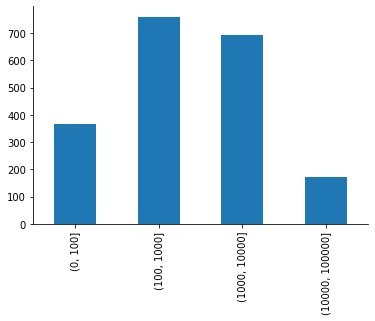

In [17]:
ax = pd.cut(df.followers_count, bins=bins).value_counts().sort_index().plot(kind='bar')
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

most of our followers have between 100 and 1000 followers.

In [18]:
sw = stopwords.words('english')

In [19]:
# adding more words IDGAF about
sw += ['//', '|', '$', '&', '/', '-', '•', '+', '@', 'views', 'own', 'tweets', 'own.',
       'former', 'formerly', 'like', "i'm", 'previously', 'opinions', 'things',
      '||', '≠', 'rt', 'rts']

In [20]:
wc = Counter()
for row in df.description:
    desc = row.lower().split(' ')
    wc.update([w for w in desc if w not in sw and w])

for k, v in wc.most_common(100):
    print(f"{k}: {v}")

data: 219
digital: 114
tech: 101
social: 93
phd: 83
editor: 82
research: 74
reporter: 70
media: 69
science: 68
she/her: 67
fellow: 64
student: 63
journalist: 62
professor: 58
researcher: 52
senior: 52
he/him: 50
news: 46
new: 45
director: 44
policy: 44
she/her.: 43
he/him.: 41
ai: 41
working: 40
public: 40
assistant: 39
journalism: 38
technology: 35
design: 34
associate: 33
prof: 33
scientist: 32
writer: 31
interested: 31
tech,: 30
alum: 29
writing: 28
author: 28
product: 26
law: 26
politics: 26
founder: 26
alum.: 26
computational: 25
open: 25
political: 25
software: 24
privacy: 24
love: 24
internet: 24
past:: 24
data,: 23
co-founder: 23
board: 23
investigative: 23
dm: 23
producer: 23
learning: 22
media,: 22
head: 22
information: 22
also: 22
work: 21
#ai: 21
currently: 21
university: 21
make: 21
big: 21
researching: 21
human: 20
@nytimes: 20
justice: 20
proud: 20
mine: 20
community: 19
online: 19
engineer: 18
web: 18
studying: 18
building: 18
computer: 18
ethics: 17
making: 17
people: 

In [21]:
description = []
for desc in df.description.tolist():
    for word in desc.lower().split():
        if word not in sw:
            description.append(word)

In [22]:
description[:5]

['cofounder', '@insightbrowser.', 'product', '@quora,', 'engineering']

In [23]:
words = re.findall('\w+', ' '.join(description))
wc = Counter(zip(words, words[1:]))

In [27]:
tuples = [
    ('t', 'co'),
    ('https', 't'),
    ('i', 'm'),
    ('protonmail', 'com'),
    ('views', 'own'),
    ('opinions', 'own'),
    ('tweets', 'own'),
    ('opinions', 'mine'),
    ('rt', 'endorsement'),
    ('rts', 'endorsements'),
    ('views', 'own'),
    ('views', 'mine'),
    ('let', 's'),
    ('views', 'expressed'),
    ('tweets', 'mine'),
    ('views', 'expressed'),
    ('i', 've'),
    ('expressed', 'own'),
    ('don', 't'),
    ('it', 's'),
    ('retweets', 'endorsements'),
    ('gmail', 'com')
]

In [28]:
for _ in tuples:
    wc.pop(_, '')

In [29]:
for (w1, w2), val in wc.most_common(50):
    print(f"{w1} {w2}: {val}")

she her: 158
he him: 138
phd student: 41
data science: 34
co founder: 32
social media: 27
data journalist: 23
assistant professor: 22
dms open: 20
associate professor: 20
data scientist: 20
phd candidate: 19
him his: 17
dm signal: 16
public policy: 14
machine learning: 14
asst prof: 14
data journalism: 13
human rights: 13
tech policy: 13
computational social: 12
her hers: 11
managing editor: 11
data reporter: 11
they them: 11
send tips: 10
digital rights: 10
grad student: 10
big data: 10
software engineer: 9
social science: 9
deep learning: 9
co host: 9
research fellow: 9
computer science: 9
personal account: 9
board member: 9
newsletter https: 9
ph d: 8
investigative reporter: 8
black lives: 8
lives matter: 8
new york: 8
senior reporter: 8
social justice: 7
research scientist: 7
writer editor: 7
ai ethics: 6
tech enthusiast: 6
we re: 6


## Follower Overlap

In [34]:
sn1 = 'themarkup' 
sn2 = 'theinformation'

In [38]:
fn1 = f'data/follower_meta_{sn1}.jsonl'
fn2 = f'data/follower_meta_{sn2}.jsonl'

In [37]:
pd.read_json?

Signature:
pd.read_json(
    path_or_buf=None,
    orient=None,
    typ='frame',
    dtype=None,
    convert_axes=None,
    convert_dates=True,
    keep_default_dates=True,
    numpy=False,
    precise_float=False,
    date_unit=None,
    encoding=None,
    lines=False,
    chunksize=None,
    compression='infer',
)
Docstring:
Convert a JSON string to pandas object.

Parameters
----------
path_or_buf : a valid JSON str, path object or file-like object
    Any valid string path is acceptable. The string could be a URL. Valid
    URL schemes include http, ftp, s3, and file. For file URLs, a host is
    expected. A local file could be:
    ``file://localhost/path/to/table.json``.

    If you want to pass in a path object, pandas accepts any
    ``os.PathLike``.

    By file-like object, we refer to objects with a ``read()`` method,
    such as a file handler (e.g. via builtin ``open`` function)
    or ``StringIO``.
orient : str
    Indication of expected JSON string format.
    Compatible

In [53]:
df_1 = pd.read_json(fn1, lines=True)
df_2 = pd.read_json(fn2, lines=True)

In [58]:
# what percentage of followers for the first account also follow account 2?
len(df_1[df_1.id.isin(df_2.id)]) / len(df_1)

0.08118599666587283

In [63]:
# public accounts that follow account 2 but not account 1
non_followers = df_2[(~df_2.id.isin(df_1.id)) & (df_2.protected == False)]
len(non_followers)

49759